# Datasets creation

In [53]:
import os

import numpy as np
import pandas as pd
from datasets import load_dataset
from functional import seq
from tqdm import tqdm

from map_generation.osm_dataset import TextToImageDataset
from srai.utils.geocode import geocode_to_region_gdf
from srai.loaders.osm_loaders.filters import GEOFABRIK_LAYERS, HEX2VEC_FILTER
from srai.regionizers import (
    SlippyMapRegionizer,
    H3Regionizer,
    AdministrativeBoundaryRegionizer,
)
from srai.loaders import OSMOnlineLoader
from srai.plotting.folium_wrapper import plot_regions
import geopandas as gpd
import pandas as pd
import shapely
import osmnx
from map_generation.config import N_COLUMNS

tqdm.pandas()

# Saving metadata to image folders
Code creates csv with tags in each city's tiles folder. Metadata.csv is used to generate captions.

Due to changes in srai.SippyMapRegionizer this code does not run with embeddings present in drive. You can skip this step - on drive are folders with created metadata.csv or use freshly created embeddings with previous notebook.

In [54]:
for city in tqdm(os.listdir("../data/tiles_own")):
    path_to_embedding = f"../data/embeddings/{city}.pkl"
    if os.path.exists(path_to_embedding):
        df: pd.DataFrame = pd.read_pickle(path_to_embedding)
        df.index = df.index + ".png"
        df.index = df.index.rename("file_name")
        df = df.reset_index()
        df = df.drop(columns=["geometry"])
        path = f"../data/tiles_own/{city}/metadata.jsonl"
        df.to_json(path, lines=True, orient="records")
    else :
        print(city, "not found")

100%|██████████| 46/46 [00:19<00:00,  2.40it/s]


In [6]:
df = pd.read_json(f"../data/tiles_own/{city}/metadata.jsonl", lines=True)
df["name"].unique()

array([None, 'suburb'], dtype=object)

In [45]:
pd.read_pickle(f"../data/admins/Chișinău, Moldova.pkl")

,admin_region,geometry,name
region_id,,,
38000_23032_16,Trușeni Commune,GEOMETRYCOLLECTION (POLYGON ((28.75732 47.0608...,village
38000_23033_16,Trușeni Commune,GEOMETRYCOLLECTION (POLYGON ((28.75732 47.0608...,village
38001_23032_16,Trușeni Commune,GEOMETRYCOLLECTION (POLYGON ((28.75732 47.0608...,village
38001_23033_16,Trușeni Commune,GEOMETRYCOLLECTION (POLYGON ((28.75732 47.0608...,village
38001_23034_16,Trușeni Commune,GEOMETRYCOLLECTION (POLYGON ((28.75732 47.0608...,village
...,...,...,...
38041_23068_16,Sîngera,"MULTIPOLYGON (((28.95170 46.92271, 28.95200 46...",town
38041_23069_16,Sîngera,"MULTIPOLYGON (((28.95170 46.92271, 28.95200 46...",town
38041_23070_16,unknown,None,unknown


# Get prepared data and push to huggingface hub

In [ ]:
ds = TextToImageDataset("../data/tiles_own/Wrocław, PL", n_columns=N_COLUMNS)

In [6]:
ds.dataset["train"].features

{'image': Image(decode=True, id=None),
 'shop_hairdresser': Value(dtype='int64', id=None),
 'natural_mud': Value(dtype='int64', id=None),
 'amenity_motorcycle_parking': Value(dtype='int64', id=None),
 'highway_trunk': Value(dtype='int64', id=None),
 'shop_garden_centre': Value(dtype='int64', id=None),
 'shop_department_store': Value(dtype='int64', id=None),
 'shop_video_games': Value(dtype='int64', id=None),
 'tourism_aquarium': Value(dtype='int64', id=None),
 'historic_citywalls': Value(dtype='int64', id=None),
 'landuse_quarry': Value(dtype='int64', id=None),
 'sport_pelota': Value(dtype='int64', id=None),
 'sport_athletics': Value(dtype='int64', id=None),
 'tourism_attraction': Value(dtype='int64', id=None),
 'landuse_industrial': Value(dtype='int64', id=None),
 'aeroway_gate': Value(dtype='int64', id=None),
 'building_barn': Value(dtype='int64', id=None),
 'amenity_car_rental': Value(dtype='int64', id=None),
 'office_religion': Value(dtype='int64', id=None),
 'amenity_bicycle_renta

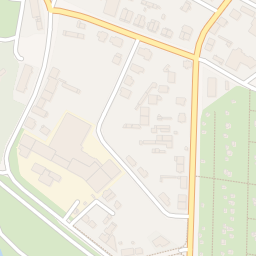

'OSM from Wrocław, Poland, Europe of suburb area containing: 36 highway footways , 2 building residentials , 4 building industrials , 5 amenity benchs , 1 water river, 1 landuse recreation ground, 13 highway paths , 1 building shed, 1 landuse allotments, 1 amenity taxi.'

In [18]:
i = 1050
display(ds[i][0])
ds[i][1]

In [19]:
hds = ds.to_huggingface_dataset()
hds.push_to_hub("mprzymus/text2tile_small_v2", private=True)

Pushing split train to the Hub.


Map:   0%|          | 0/2144 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

In [55]:
large_ds = TextToImageDataset("../data/tiles_own").to_huggingface_dataset()
large_ds.push_to_hub("mprzymus/text2tile_large")

None


Resolving data files:   0%|          | 0/116838 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/marcin/.cache/huggingface/datasets/imagefolder/tiles_own-ac728ca8a5a6f100/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/116792 [00:00<?, ? examples/s]

Pushing split train to the Hub.


Map:   0%|          | 0/10618 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/11 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10618 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10618 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10618 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10618 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10617 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10617 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10617 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10617 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10617 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10617 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/11 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/4 [00:00<?, ?it/s]

# Check download works

In [6]:
ds = load_dataset("mprzymus/text2tile")
test_captions = ds["test"]["caption"]

Found cached dataset parquet (/home/marcin/.cache/huggingface/datasets/mprzymus___parquet/mprzymus--text2tile-08c7471b58d60160/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
test_captions[843]

'OSM of area containing: 4 landuse meadows  , 3 landuse farmlands  , 1 natural scrub  , 1 natural water  , 1 water river  .'

In [14]:
test_captions[290]

'OSM of area containing: 2 leisure playgrounds  , 1 shop seafood  , 59 buildings  , 1 shop computer  , 1 office government  .'

In [15]:
test_captions[253]

'OSM of area containing: 2 leisure pitchs  , 191 building apartmentss  , 3 amenity parkings  , 1 amenity fuel  , 2 building industrials  .'

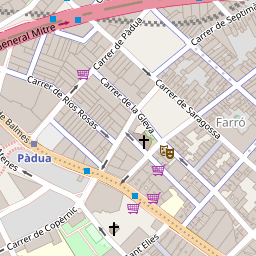

In [16]:
ds["test"]["image"][253]